# STA2453 - Data Science Methods, Collaboration, and Communication

# Credit Card Fraud Detection

### Team -
#### Pulkit Mathur
#### Angad Kalra
#### Shaung

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
whole_data = pd.read_csv('UofT/credit_card_fraud_data_v2.csv')
whole_data.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


## Exploratory Data Analysis

##### Transaction Distribution

In [3]:
Count_Fraud_transacation = len(whole_data[whole_data['Is_Fraud']==1])
print("Number of fraud transactions-",Count_Fraud_transacation)
Count_Normal_transacation = len(whole_data[whole_data['Is_Fraud']==0])
print("Number of non-fraud transactions-",Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("Percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

Number of fraud transactions- 18213
Number of non-fraud transactions- 6354407
Percentage of fraud transacation 0.2858008166185964


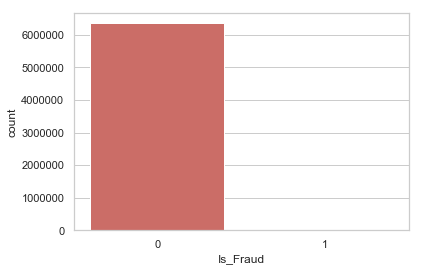

In [4]:
sns.countplot(x='Is_Fraud',data=whole_data, palette='hls')
plt.show()

#### Types of transactions

In [5]:
print(whole_data['Transaction_Type'].unique())

['BILL-PAYMENT' 'PURCHASE' 'CASH_OUT' 'DEBIT' 'CASH_IN']


#### Number of entries per customer

In [6]:
print("MAX:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().max())
print("MEAN:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().mean())
print("MIN:",whole_data.groupby(['Client_Id'])['Time_Stamp'].count().min())

MAX: 1010
MEAN: 6.692895109683694
MIN: 1


#### Transaction type for fradulent transaction

In [7]:
whole_data[whole_data['Is_Fraud']==1].groupby(['Transaction_Type']).count()['Is_Fraud']

Transaction_Type
CASH_OUT    9116
PURCHASE    9097
Name: Is_Fraud, dtype: int64

#### Transaction type for non- fradulent transaction

In [8]:
whole_data[whole_data['Is_Fraud']==0].groupby(['Transaction_Type']).count()['Is_Fraud']

Transaction_Type
BILL-PAYMENT    2151495
CASH_IN         1399284
CASH_OUT        2233384
DEBIT             41432
PURCHASE         528812
Name: Is_Fraud, dtype: int64

#### How efficient is Is_fault flagging??

In [9]:
((whole_data['Is_Fraud']==1) & (whole_data['Is_Flagged_Fraud']==1)).value_counts()

False    6372604
True          16
dtype: int64

In [10]:
print('percentage of data that was rightly classified:')
(16/len(whole_data[whole_data['Is_Fraud']==1]))*100

percentage of data that was rightly classified:


0.0878493383846703

## Feature Engineering

In [11]:
whole_data['Client_change_in_balance'] = whole_data['Cleint_New_Balance'] - whole_data['Client_Old_Balance']
whole_data['Merchant_change_in_balance'] = whole_data['Merchant_New_Balance'] - whole_data['Merchant_Old_Balance']
whole_data['percentage_of_balance'] = (whole_data['Amount']/whole_data['Client_Old_Balance']) *100

#### Some strange Facts

In [12]:
whole_data[(whole_data['Client_Old_Balance']==0) & (whole_data['Cleint_New_Balance']==0) & (whole_data['Amount']==0)].head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance
2736447,212,CASH_OUT,0.0,C1533131508,0.0,0.0,M1608767807,0.00,0.00,1,0,0.0,0.0,NaN
3247298,250,CASH_OUT,0.0,C1780497316,0.0,0.0,M20822566,0.00,0.00,1,0,0.0,0.0,NaN
3760289,279,CASH_OUT,0.0,C881485517,0.0,0.0,M1668533071,538547.63,538547.63,1,0,0.0,0.0,NaN
5563714,387,CASH_OUT,0.0,C647787714,0.0,0.0,M1913451129,7970766.57,7970766.57,1,0,0.0,0.0,NaN
5996408,425,CASH_OUT,0.0,C1654239658,0.0,0.0,C2068374328,76759.90,76759.90,1,0,0.0,0.0,NaN


If the Client old balance == 0 & Client new balance == 0 & Amount == 0
then transaction is fradulent

In [13]:
# Replacing NAN with 0
whole_data['percentage_of_balance'] = whole_data['percentage_of_balance'].fillna(0)
# Replacing infinity values with -1 (Rows with amount>0 and Client old balance == 0)
whole_data['percentage_of_balance'] = whole_data['percentage_of_balance'].replace([np.inf], -1)

#### Checking consistency of Data

#### Amount == Change in Balance

In [14]:
whole_data[whole_data['Amount']==abs(whole_data['Client_change_in_balance'])].groupby('Is_Fraud').size()

Is_Fraud
0    920951
1     18144
dtype: int64

#### Amount != Change in Balance

In [15]:
whole_data[whole_data['Amount']!=abs(whole_data['Client_change_in_balance'])].groupby('Is_Fraud').size()

Is_Fraud
0    5433456
1         69
dtype: int64

#### Amount distribution for fradulent (1) and non-fradulent (0) transactions

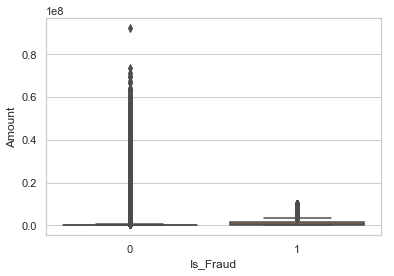

In [16]:
sns.set(style="whitegrid")
sns.boxplot(x="Is_Fraud", y="Amount", data=whole_data)
plt.show()

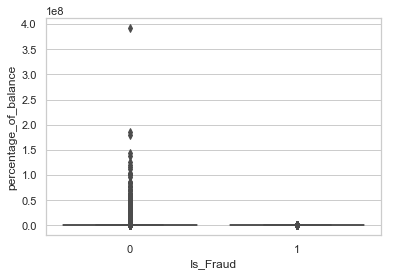

In [17]:
sns.boxplot(x="Is_Fraud", y="percentage_of_balance", data=whole_data)
plt.show()

In [18]:
model_data = whole_data.drop(columns=['Client_Id', 'Merchant_Id','Is_Flagged_Fraud','Time_Stamp'])
model_data = pd.get_dummies(model_data, columns=['Transaction_Type'])
model_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
0,9839.64,170136.0,160296.36,0.0,0.0,0,-9839.64,0.0,5.783397,1,0,0,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,-1864.28,0.0,8.773495,1,0,0,0,0
2,181.00,181.0,0.00,0.0,0.0,1,-181.00,0.0,100.000000,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,-181.00,-21182.0,100.000000,0,0,1,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,-11668.14,0.0,28.079463,1,0,0,0,0


In [19]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = ['Amount','Client_Old_Balance','Cleint_New_Balance','Merchant_Old_Balance','Merchant_New_Balance','Client_change_in_balance',
'Merchant_change_in_balance','percentage_of_balance']
model_data[cols_to_norm] = StandardScaler().fit_transform(model_data[cols_to_norm])
model_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
0,-0.276350,-0.230542,-0.237475,-0.324504,-0.333994,0,-0.117119,-0.153388,-0.024027,1,0,0,0,0
1,-0.289043,-0.282022,-0.285699,-0.324504,-0.333994,0,-0.082703,-0.153388,-0.024018,1,0,0,0,0
2,-0.291722,-0.289306,-0.292333,-0.324504,-0.333994,1,-0.075439,-0.153388,-0.023750,0,0,0,0,1
3,-0.291722,-0.289306,-0.292333,-0.318278,-0.333994,1,-0.075439,-0.179163,-0.023750,0,0,1,0,0
4,-0.273440,-0.275001,-0.282105,-0.324504,-0.333994,0,-0.125009,-0.153388,-0.023962,1,0,0,0,0


Distributions: 

Number of fraud transactions- 18213
Number of non-fraud transactions- 6354407

By seeing the distributions we can have an idea how skewed are these features are. There are techniques that can help the distributions be less skewed. Let's try them !!

##### Random- Under Sampling
This method consists of removing data in order to have a more balanced dataset and thus avoiding the model to overfit.

Steps:

1) Determine how imbalanced is our class is.

2) Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio)

3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 18213 non-fraud transaction from 6354407 non-fraud transaction)

In [20]:
# Shuffle the data before creating the subsamples

model_data = model_data.sample(frac=1, random_state=10)

# amount of fraud classes 18213 rows.
fraud_df = model_data.loc[model_data['Is_Fraud'] == 1]
non_fraud_df = model_data.loc[model_data['Is_Fraud'] == 0][:18213]

combined_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
undersampled_data = combined_df.sample(frac=1, random_state=14)

undersampled_data.head()

,Amount,Client_Old_Balance,Cleint_New_Balance,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Client_change_in_balance,Merchant_change_in_balance,percentage_of_balance,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE
6370325,1.344915,0.066252,-0.292333,-0.324504,-0.054746,1,-4.512995,1.098149,-0.023750,0,0,1,0,0
1030418,-0.241758,-0.278452,-0.292333,-0.265903,-0.271287,1,-0.210911,-0.114966,-0.023750,0,0,1,0,0
6365470,0.667383,-0.080941,-0.292333,-0.324504,-0.333994,1,-2.675942,-0.153388,-0.023750,0,0,0,0,1
6365385,1.344915,0.066252,-0.292333,-0.324504,-0.054746,1,-4.512995,1.098149,-0.023750,0,0,1,0,0
2709806,-0.282109,-0.264849,-0.270193,-0.324504,-0.333994,0,-0.101503,-0.153388,-0.024018,1,0,0,0,0


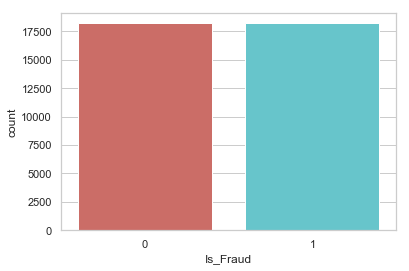

In [21]:
sns.countplot(x='Is_Fraud',data=undersampled_data, palette='hls')
plt.show()

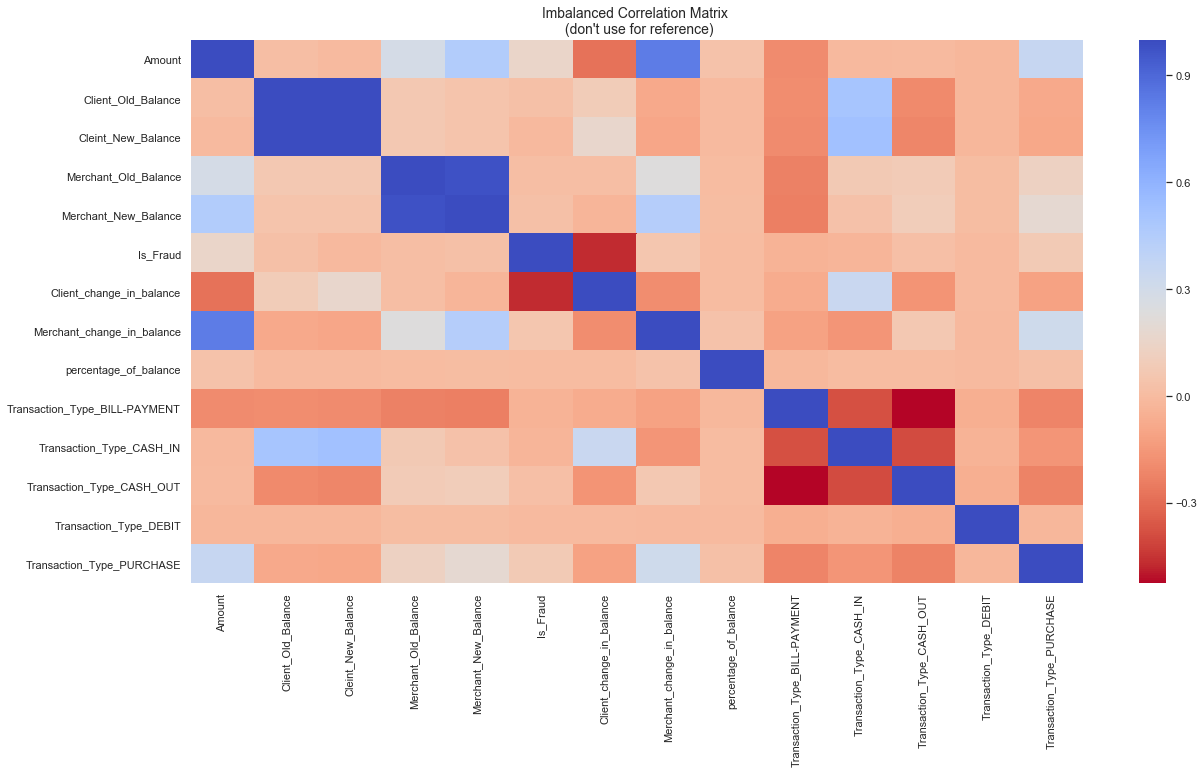

In [22]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))

corr = model_data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)
plt.show()

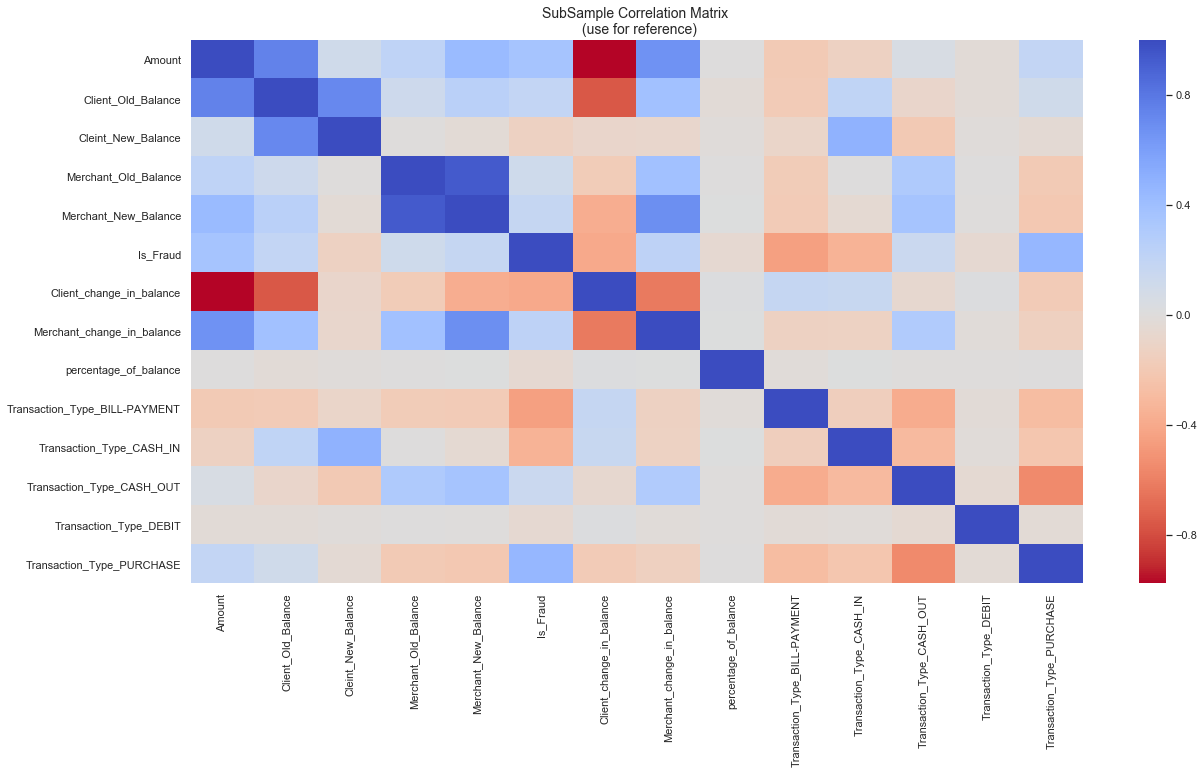

In [23]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
sub_sample_corr = undersampled_data.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### Spliting the Data

In [24]:
from sklearn.model_selection import train_test_split
X = undersampled_data.iloc[:, undersampled_data.columns != 'Is_Fraud']
y = undersampled_data.iloc[:, undersampled_data.columns == 'Is_Fraud']
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset from unsampled  dataset: ", len(X_train))
print("Number transactions test dataset from unsampled  dataset: ", len(X_test))
print("Total number of transactions in unsampled  dataset: ", len(X_train)+len(X_test))

Number transactions train dataset from unsampled  dataset:  25498
Number transactions test dataset from unsampled  dataset:  10928
Total number of transactions in unsampled  dataset:  36426


In [25]:
y_train = np.array(y_train).flatten()

### Logistic Regression

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


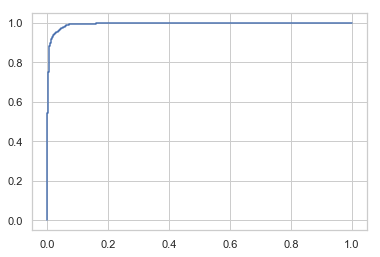

AUC: 0.9946000805218244
Accuracy: 0.9607430453879942
F1 score: 0.9604353038826893


In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
model = LogisticRegressionCV(penalty='l2', cv=5,max_iter=2000)
model = model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()
print("AUC:",roc_auc_score(y_test, y_pred[:,1]))
print("Accuracy:",model.score(X_test, y_test))
y_hat = model.predict(X_test)
print("F1 score:",f1_score(y_test, y_hat))

### SVM

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


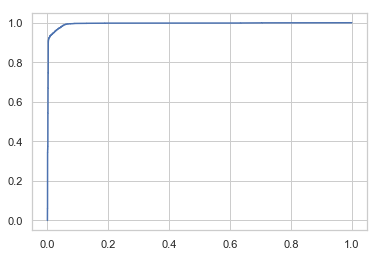

AUC: 0.9949346111874423
Accuracy: 0.9652269399707174
F1 score: 0.9648343512863226


In [28]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)
y_pred = svm_model.predict_proba(X_test)
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()
print("AUC:",roc_auc_score(y_test, y_pred[:,1]))
print("Accuracy:",svm_model.score(X_test, y_test))
y_hat = svm_model.predict(X_test)
print("F1 score:",f1_score(y_test, y_hat))

### Random Forest

c:\users\pulkit\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


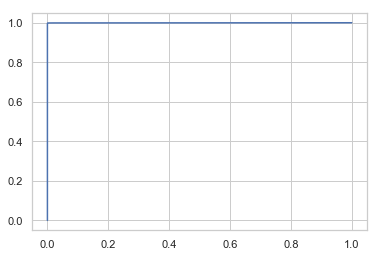

AUC: 0.9995288267461078
Accuracy: 0.9989019033674963
F1 score: 0.9989000916590285


In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_test)
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()
print("AUC:",roc_auc_score(y_test, y_pred[:,1]))
print("Accuracy:",rf_model.score(X_test, y_test))
y_hat = rf_model.predict(X_test)
print("F1 score:",f1_score(y_test, y_hat))

### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
num_nbrs = [5, 10, 15, 20, 25, 30]

for k in num_nbrs:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model = knn_model.fit(X_train, y_train)
    acc = knn_model.score(X_test, y_test)
    y_pred = knn_model.predict(X_test)
    print("k={0}, acc: {1}, f1-score: {2}".format(k, acc, f1_score(y_test, y_pred)))

k=5, acc: 0.9808748169838946, f1-score: 0.9810224280395896
k=10, acc: 0.9799597364568082, f1-score: 0.98007098007098
k=15, acc: 0.9777635431918009, f1-score: 0.9779671774412911
k=20, acc: 0.9771229868228404, f1-score: 0.9773098565982937
k=25, acc: 0.9754758418740849, f1-score: 0.9757114373753852
k=30, acc: 0.9750183016105417, f1-score: 0.9752291080664186
